### Github link: https://github.com/R0ner/comsosci-assignments
### All group members contributed equally to all parts of the assignment

# Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import networkx as nx
import netwulf as wulf
import datetime as dt
import shifterator as sh
import nltk
import re
import random
import json
import community

from wordcloud import WordCloud
from networkx.readwrite import json_graph
from collections.abc import Iterable
from collections import Counter
from scipy import stats

## Part 1: TF-IDF

### Preliminaries

In [2]:
submissions = pd.read_csv('wallstreet_subs.csv')
submissions['date'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.date
submissions['date'] = pd.to_datetime(submissions['date'])
submissions.head()

,created_utc,title,selftext,score,date
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06


In [3]:
submissions['text'] = submissions['title'] + ' ' + submissions['selftext']
submissions.head()

,created_utc,title,selftext,score,date,text
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a..."
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca..."
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...


In [4]:
regex = '^\$\w+'

In [5]:
tickers = submissions['text'].str.findall(regex).sum()

tickers = [ticker.upper() for ticker in tickers if not bool(re.search(r'\d', ticker))]

unique_tickers, counts = np.unique(tickers, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
top_15 = unique_tickers[sorted_indices][:15]
top_15

array(['$TSLA', '$SPCE', '$SPY', '$PLTR', '$NIO', '$MSFT', '$ZM', '$AAPL',
       '$BABA', '$PTON', '$GME', '$DIS', '$BA', '$RKT', '$NKLA'],
      dtype='<U27')

### 1.
Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens.

In [6]:
# Stop words are removed from the tokenized text. We get the stop words here.
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = [re.sub('[^a-z_-]', '', stop_word) for stop_word in stop_words]

def tokenize(text: str) -> list[str]:
    """Tokenizer function. 
    The following is removed from the tokenized text:
    Symbols, stop words and URL's.
    
    Finally, only unique words are included in the tokens (ie. no repeats)"""
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and 'http' not in word and len(word) > 1]
    tokens = list(set(tokens))
    return tokens

In [7]:
# The tokenized text is saved in a new column
submissions['tokens'] = submissions.apply(lambda row: tokenize(row['text']), axis=1)
submissions.head()

,created_utc,title,selftext,score,date,text,tokens
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[lqd, buy, nav, unemployment, coming, buying, ..."
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[googled, ignorance, bliss, shares, got, virus..."
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[literally, us, know, buy, boredom, stonks, no..."
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[found, us, took, describe, market, begin, tak..."
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[anyone, know, huge, stock, right, market, tra..."


### 2. 
Find submissions discussing at least one of the top 15 stocks you identified above

In [8]:
# Intersection functino
top_15_set = set([re.sub('[^a-z]', '', stock.lower()) for stock in top_15])
isect = lambda row: list(top_15_set.intersection(set(row['tokens'])))

In [9]:
# Apply the intersection function and add the results to a new column
submissions['stock'] = submissions.apply(isect, axis=1)
submissions.head()

,created_utc,title,selftext,score,date,text,tokens,stock
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[lqd, buy, nav, unemployment, coming, buying, ...",[]
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[googled, ignorance, bliss, shares, got, virus...",[]
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[literally, us, know, buy, boredom, stonks, no...",[]
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[found, us, took, describe, market, begin, tak...",[]
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[anyone, know, huge, stock, right, market, tra...",[]


In [10]:
# Explode the stock column such that texts discussing multiple stocks are duplicated
submissions = submissions.explode('stock')

# Handle cases where the top 15 stocks are not discussed
submissions.loc[submissions['stock'].isnull(), 'stock'] = 'other'
submissions.head()

,created_utc,title,selftext,score,date,text,tokens,stock
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,2020-04-06,"What is the Fed actually buying? Okay, I may a...","[lqd, buy, nav, unemployment, coming, buying, ...",other
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,2020-04-06,I didn’t learn about puts because I was lazy B...,"[googled, ignorance, bliss, shares, got, virus...",other
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,2020-04-06,HOT TAKE Literally everyone has free time on t...,"[literally, us, know, buy, boredom, stonks, no...",other
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,2020-04-06,"Fuck you Gordon Gordon I believed in you, I ca...","[found, us, took, describe, market, begin, tak...",other
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,2020-04-06,Can’t find a picture Someone uploaded a ohoto ...,"[anyone, know, huge, stock, right, market, tra...",other


### 3. 
Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.

In [11]:
# Create the documents as a dictionary
# We exclude the document including discussions that do not relate to the top 15 stocks
# as it is not used (and very large)
documents = {stock: list(np.concatenate(tuple(submissions.loc[submissions['stock'] == stock, 'tokens']))) for stock in top_15_set}

### 4. 
Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 

In [12]:
# Chose the stocks for the following companies:
# Tesla, Gamestop, Apple, Zoom and Disney
stonks = ['tsla', 'gme', 'aapl', 'zm', 'dis']

In [13]:
def term_frequency(document: list) -> tuple[np.array, np.array]:
    """This function calculates the term frequency of a document.
    The term frequency is normalized by the total number of words in the document.
    Returns a tuple of arrays. The first array is the terms and the second array is
    the term frequency in the same order.
    
    Arguments:
        document (np.array): array of tokens.
    """
    fdist = nltk.FreqDist(document)
    n_words = fdist.N()
    terms = np.array(list(fdist.keys()))
    tf = np.array(list(fdist.values())) / n_words
    
    return tf, terms


def inverse_document_frequency(documents: dict[list], corpus=None) -> dict[float]:
    """This function computes the inverse document frequency (idf) given
    a list of documents and a set of terms.
    """
    if corpus is None:
        corpus = documents.keys()
    
    n_documents = len(corpus)
    terms, counts = np.unique(
        np.concatenate([list(set(documents[d])) for d in corpus]),
        return_counts=True
    )
    
    idf = np.log(n_documents / (counts))
    idf_lookup = {term: w for term, w in zip(terms, idf)}
    
    return idf_lookup

def tf_idf(document: list, idf_lookup: dict[float]) -> tuple[np.array, np.array]:
    """Computes the tf-idf of a document, given a document and a lookup table for idf."""
    tf, terms = term_frequency(document)
    idf = np.array([idf_lookup[term] for term in terms])
    
    return tf * idf, terms

In [14]:
# Top 5 words, TF
print('Top 5 terms sorted by term frequency (TF):')

for stock in stonks:
    tf, terms = term_frequency(documents[stock])
    sorted_indices = np.argsort(tf)[::-1]
    stock_top_5 = terms[sorted_indices[:5]]
    print(f'${stock.upper()}:')
    print(stock_top_5)

Top 5 terms sorted by term frequency (TF):
$TSLA:
['tsla' 'like' 'calls' 'buy' 'stock']
$GME:
['gme' 'shares' 'short' 'buy' 'going']
$AAPL:
['aapl' 'calls' 'like' 'market' 'buy']
$ZM:
['zm' 'like' 'zoom' 'market' 'going']
$DIS:
['dis' 'puts' 'like' 'disney' 'market']


* Describe similarities and differences between the stocks.

Answer:  
Expectedly, the number 1 term for all the stocks is the stock itself. Apart from that, there are a lot of similiarities between the top 5 terms by term frequency. The top 5 terms seem to revolve investing in general rather than the specific stocks

* Why aren't the TFs not necessarily a good description of the stocks?

Answer:  
Term frequency accounts for the total frequency of a term, and therefore weighs terms that are common in all documents in a corpus highly. To properly describe the stock documents, we are interested in the words that are common in one document, and not the others.

* Next, we calculate IDF for every word. 

In [15]:
idf_lookup = inverse_document_frequency(documents, stonks)

* What base logarithm did you use? Is that important?

Answer: 
We used the natural logarithm. The choice of logarithm base does not matter, as the relative differences between numbers on the log scale are independent of the base

### 5. 
We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
* List the 10 top TF words for each stock.
* List the 10 top TF-IDF words for each stock.

In [16]:
# Top 10 words, TF
print('Top 10 terms sorted by term frequency (TF):')

topx = 10
for stock in stonks:
    tf, terms = term_frequency(documents[stock])
    sorted_indices = np.argsort(tf)[::-1]
    stock_top_10 = terms[sorted_indices[:topx]]
    # print(tf[sorted_indices[:topx]])
    print(f'${stock.upper()}:')
    print(stock_top_10)
    
print('\n')

# Top 10 words, TF-IDF
print('Top 10 terms sorted by TF-IDF:')


for stock in stonks:
    tfidf, terms = tf_idf(documents[stock], idf_lookup)
    sorted_indices = np.argsort(tfidf)[::-1]
    stock_top_10 = terms[sorted_indices[:topx]]
    # print(tfidf[sorted_indices[:topx]])
    print(f'${stock.upper()}:')
    print(stock_top_10)

Top 10 terms sorted by term frequency (TF):
$TSLA:
['tsla' 'like' 'calls' 'buy' 'stock' 'get' 'market' 'going' 'amp' 'tesla']
$GME:
['gme' 'shares' 'short' 'buy' 'going' 'get' 'like' 'know' 'calls'
 'squeeze']
$AAPL:
['aapl' 'calls' 'like' 'market' 'buy' 'tsla' 'go' 'apple' 'time' 'amp']
$ZM:
['zm' 'like' 'zoom' 'market' 'going' 'amp' 'com' 'earnings' 'stock' 'one']
$DIS:
['dis' 'puts' 'like' 'disney' 'market' 'going' 'calls' 'get' 'buy' 'go']


Top 10 terms sorted by TF-IDF:
$TSLA:
['lithium' 'teslas' 'fsd' 'musky' 'inclusion' 'scalping' 'gigafactory'
 'splits' 'autonomous' 'autonomy']
$GME:
['melvin' 'sherman' 'uberkikz' 'bestbuy' 'moass' 'squeezes' 'icr' 'xbox'
 'gamestops' 'reggie']
$AAPL:
['splits' 'lvls' 'splitting' 'decimals' 'ipad' 'macrumors' 'macs'
 'fractional' 'sono' 'nephew']
$ZM:
['webex' 'bidder' 'slacks' 'cldr' 'slack' 'eght' 'classroom'
 'teleconferencing' 'conferencing' 'ringcentral']
$DIS:
['mickey' 'orlando' 'widow' 'marvel' 'pixar' 'mulan' 'yoda' 'espn' 'walt'
 'lb

* Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

Answer:  
The top 10 terms by TF-IDS are more much more specific than the ones found by TF. For instance, for zoom, we get 'eight' and 'ringcentral' which are companies that compete with zoom in the teleconferencing space. For tesla we get words revolving around self driving and lithium batteries, which is also very specific. 

The terms found by TF-IDF seems to much more informative than the ones found by TF. Inverse document frequency (IDF) weighs each term inverse to how many documents they appear in logarithmically. This means that terms that only occur in a small fraction of the documents in a corpus are weighed the most. On the other hand, terms that occur in a large fraction of the documents are weighed the least. The effect of weighing TF by IDF is that words that words that are both common and occur in very few documents is weighed heighest, which is much more informative than pure TF.

### 6. 
Visualize the results in a Wordcloud and comment on your results.

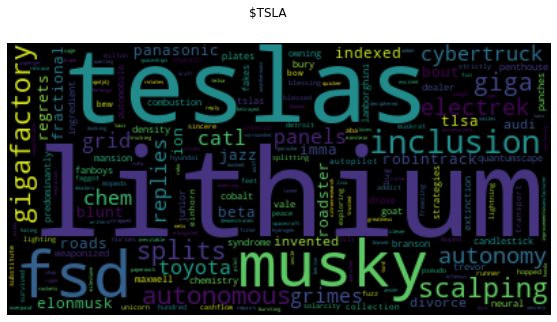

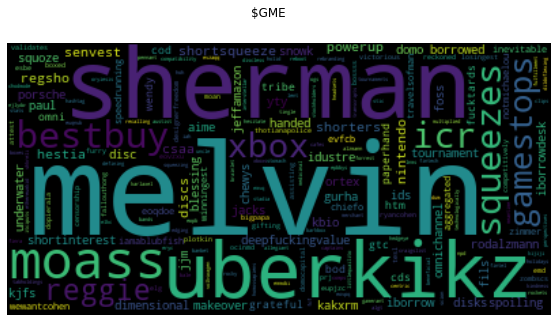

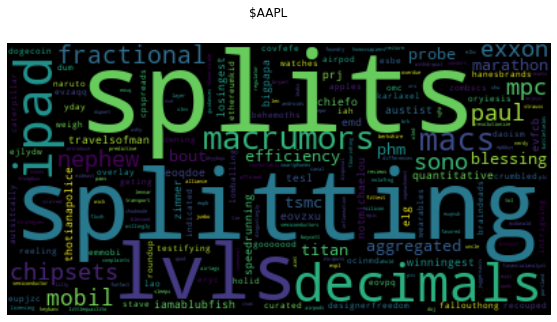

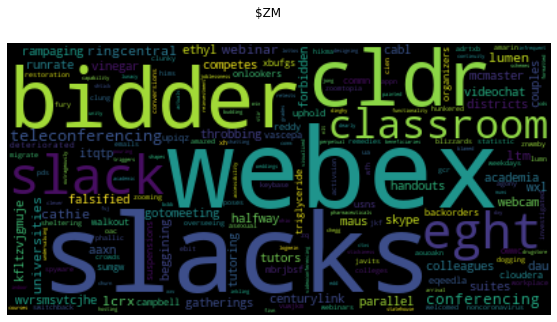

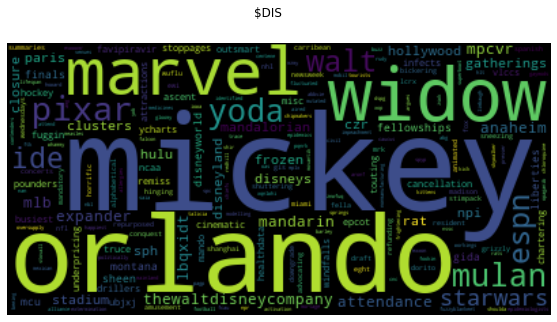

In [17]:
# Generate a word cloud image
for stock in stonks:
    tfidf, terms = tf_idf(documents[stock], idf_lookup)
    wc = WordCloud().generate_from_frequencies({term: w for w, term in zip(tfidf, terms)})
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    fig.suptitle(f'${stock.upper()}', fontsize='large')
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    plt.show()

The word cloud is a great way to a get a feel for the results. We think it looks pretty good, and it makes a lot of sense.

## Part 2: Sentiment analysis

### Preliminaries

In [18]:
hedonometer = pd.read_csv('Hedonometer.csv')
hedonometer.head()

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
0,0,laughter,laughter,8.50,0.93
1,1,happiness,happiness,8.44,0.97
2,2,love,love,8.42,1.11
3,3,happy,happy,8.30,0.99
4,4,laughed,laughed,8.26,1.16


In [19]:
hed_dict = hedonometer.loc[:, ('Word', 'Happiness Score')].set_index('Word')['Happiness Score'].to_dict()

In [20]:
def doc2score(doc: list[str]) -> float:
    """Computes the happiness score of a document (list of tokens)."""
    count = Counter(doc)
    n_words = 0
    score = 0
    for term, freq in count.items():
        if term in hed_dict:
            n_words += freq
            score += hed_dict[term] * freq
    score /= n_words
    return score

In [21]:
daily_words = submissions.groupby('date').agg({'tokens': sum})['tokens']
daily_words.head()

date
2019-12-31    [responsible, us, tendencies, using, buying, e...
2020-01-01    [eve, home, ringing, butt, year, ya, guys, new...
2020-01-02    [believe, baba, forecast, say, year, range, po...
2020-01-03    [looking, hormuz, etf, stocks, wwiii, obscure,...
2020-01-04    [found, know, buy, europe, anything, wan, offe...
Name: tokens, dtype: object

In [22]:
daily_happiness = pd.Series({date: doc2score(doc) for date, doc in zip(daily_words.index, daily_words.values)})
daily_happiness.head()

2019-12-31    5.725481
2020-01-01    5.634265
2020-01-02    5.578427
2020-01-03    5.475959
2020-01-04    5.558981
dtype: float64

### 1. 
Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

In [23]:
# We picked christmas eve :^) 
d = '2020-12-24'

### 2. 
Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [24]:
# Convert day to datetime
d = dt.datetime.strptime(d, '%Y-%m-%d').date()
dmin = d - dt.timedelta(days=7)
d, dmin = str(d), str(dmin)
d, dmin

('2020-12-24', '2020-12-17')

In [25]:
l = daily_words.loc[d]
lref = daily_words[(daily_words.index<d) & (daily_words.index>dmin)].values.sum()
len(l), len(lref)

(21134, 80256)

### 3. 
For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [26]:
def topx(d: dict[float], x=10) -> None:
    """Helper function to print top x items of a dictionary of floats."""
    print(sorted(d.items(), key=lambda y: y[1], reverse=True)[:x])

In [27]:
# Relative frequency
n_l = len(l)
n_lref = len(lref)
p = {token: freq / n_l for token, freq in Counter(l).items()}
pref = {token: freq / n_lref for token, freq in Counter(lref).items()}

print('Top 10 terms by frequency:')
print(f'\n{d}')
topx(p)

print(f'\nBetween {dmin} and {d}')
topx(pref)

Top 10 terms by frequency:

2020-12-24
[('stock', 0.0044004920980410716), ('like', 0.003738052427368222), ('get', 0.003454149711365572), ('market', 0.003454149711365572), ('gme', 0.0033121983533642473), ('going', 0.003170246995362922), ('stocks', 0.0030756127566953723), ('money', 0.0030756127566953723), ('time', 0.0030282956373615974), ('amp', 0.0029809785180278225)]

Between 2020-12-17 and 2020-12-24
[('amp', 0.003937400318979266), ('like', 0.0036383572567783096), ('com', 0.0035511363636363635), ('stock', 0.0033891547049441787), ('buy', 0.0032396331738437003), ('get', 0.003189792663476874), ('market', 0.003189792663476874), ('time', 0.0030901116427432215), ('going', 0.003052731259968102), ('one', 0.0029904306220095694)]


### 4. 
For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [28]:
all_tokens = set(p.keys()).union(set(pref.keys()))

dp = {token: p.get(token, 0) - pref.get(token, 0) for token in all_tokens}

print(f'Change in frequency of terms for {d} compared to the prior week')
topx(dp)

Change in frequency of terms for 2020-12-24 compared to the prior week
[('baba', 0.0021166534148546173), ('gme', 0.0013808785766497337), ('many', 0.0012567477834533164), ('stocks', 0.0012065936179393914), ('christmas', 0.0010729965709049675), ('stock', 0.0010113373930968929), ('merry', 0.0009537557322011034), ('buying', 0.0009107012570656837), ('jack', 0.0007644872548660035), ('days', 0.0007465098624875462)]


The top 10 tokens by relative frequency show which words are used more on day $d$ compared the prior 7 days. We see that 'christmas' and 'merry' is mentioned more, which makes a lot of sense given that we've chosen $d = christmas\_eve$.

### 5. 
Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [29]:
h = {token: hed_dict[token] - 5 for token in all_tokens if token in hed_dict}

dPhi = {token: h[token] * dp[token] for token in h}

### 6. 
Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [30]:
dPhi_abs = {token: abs(value) for token, value in dPhi.items()}

topx(dPhi_abs)

[('christmas', 0.003176069849878704), ('merry', 0.0024416146744348243), ('thanks', 0.0015414061017802558), ('money', 0.0013995672351361987), ('buying', 0.0012749817598919574), ('profit', 0.001250254508747932), ('real', 0.0012114215253122439), ('holidays', 0.001105530910908128), ('covid', 0.0010944953908446884), ('pretty', 0.0010732485798449595)]


We have now weighed the relative frequency of the terms by their happiness score. This means that words that have seen a large change in relative frequency and have a large absolute happiness score is weighed the heighest. With this in mind, the top 10 terms shown above make a lot of sense: We see that christmas, which is used more frequently compared to prior week and has a large happiness score is weighed heightest. We also see that covid, which has a very low happiness score, is included in the top ten when it wasn't in the top by relative frequency.

### 8. 
Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. 

In [31]:
sentiment_shift = sh.WeightedAvgShift(
    type2freq_1=pref,
    type2freq_2=p,
    type2score_1=hed_dict,
    reference_value=5
)

C:\Users\runes\.conda\envs\comsosci\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


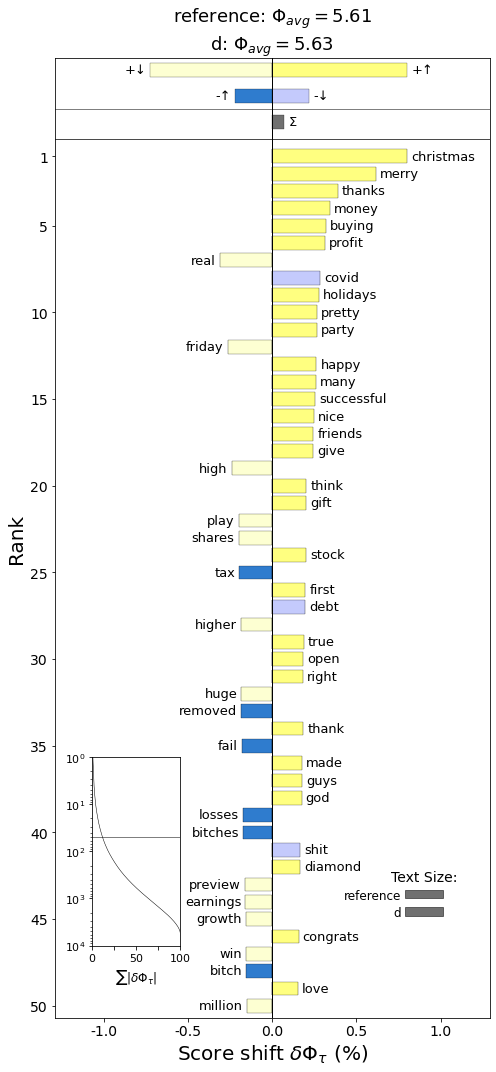

In [32]:
sentiment_shift.get_shift_graph(
    detailed=True,
    system_names=['reference', 'd']
)
plt.show()

* Comment on the figure. 

Answer:  
The figure shows which words contribute to the happiness score changing on that particular day compared to the reference period, ie. the word shift. We chose Christmas Eve to do our analysis, and the figure shows what one might expect. The happiness score shifted up, and words pertaining to the holidays were used more :)

* How do words that you printed in step 6 relate to those shown by the WordShift?

Answer:  
The words ranked 0-10 in the figure are exactly the same as the ones printed in step 6. The figure does a great job of visualizing how the change in usage of the words contribute to the observed happiness score shift..


## Part 3: Communities for the Zachary Karate Club Network

In [33]:
graph = nx.karate_club_graph()

for k, v in graph.nodes(data=True):
    v['group'] = v['club'];
    del v['club']

stylized_network, config = wulf.visualize(graph)

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [34]:
def modularity(graph, partition):
    groups = {data[partition] for node, data in graph.nodes(data=True)}
    subgraphs = []
    for group in groups:
        nodes = [node for node, data in graph.nodes(data=True) if data.get(partition) == group]
        subgraphs.append(graph.subgraph(nodes))
        
    M = 0
    L = graph.number_of_edges()
    for subgraph in subgraphs:
        kc = sum(i[1] for i in subgraph.degree)
        Lc = subgraph.number_of_edges()
        M += Lc / L - (kc/(2*L))**2
        
    return M

> 3. Explain in your own words the concept of _modularity_. 

Modularity measures how well a given partition models the actual structure of the network. If edges are likely to lie within groups, and unlikely to go between them, the partition has a high modularity, and is a good model of the network structure. Since modularity gives us a numerical way to assign 'quality' to a partition, it can be used to automatically find communities in graphs, by simply looking for the partition(s) that maximize modularity.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [35]:
m = modularity(graph, 'group')
print(f"The modularity of the club split is: {m:.3f}")

The modularity of the club split is: 0.489


> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,3,2,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element. (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__


In [36]:
#a
copy = graph.copy()

#b
sources, targets = list(map(list, zip(*list(copy.edges()))))

#c
stubs = sources + targets

#d
random.shuffle(stubs)
random_edges = [(i, j) for i, j in zip(stubs[::2], stubs[1::2])]

#e
copy.remove_edges_from(copy.edges())
copy.add_edges_from(random_edges)

> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? __Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory%29#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). __Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)

In [37]:
print("Total degree of original:", sum(i[1] for i in graph.degree))
print("Total degree of random:", sum(i[1] for i in copy.degree))
print("\n")
print("Edges in original:", len(graph.edges()))
print("Edges in random:", len(copy.edges()))
print("\n")
print("Are there any repeat edges?", any(i == j for i, j in random_edges))

Total degree of original: 156
Total degree of random: 140


Edges in original: 78
Edges in random: 70


Are there any repeat edges? True


Notes for the above: Even though a random network should have higher degree due to self-loops, it also loses entire edges in this implementation becaues the standard NetworkX networks simply discard edges when multiple are present between the same two nodes.

In [38]:
des_graph = nx.double_edge_swap(graph.copy(), nswap=1000, max_tries=10000)
print("Edges in double edge swap graph:", len(des_graph.edges))
print("Total degree of double edge swap graph:", sum(i[1] for i in des_graph.degree))
print("Do the individual degrees match?", all(i[1] == j[1] for i, j in zip(graph.degree, des_graph.degree)))

Edges in double edge swap graph: 78
Total degree of double edge swap graph: 156
Do the individual degrees match? True


> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [39]:
from tqdm import tqdm
modularities = []
for _ in tqdm(range(5000)):
    g = nx.double_edge_swap(graph.copy(), nswap=500, max_tries=10000)
    m = modularity(g, "group")
    modularities.append(m)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:22<00:00, 60.73it/s]


> 8. Compute the average and standard deviation of the modularity for the configuration model.

In [40]:
print("Mean modularity:", np.mean(modularities))
print("Std  modularity:", np.std(modularities))

Mean modularity: 0.364294674556213
Std  modularity: 0.024878165331792285


> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

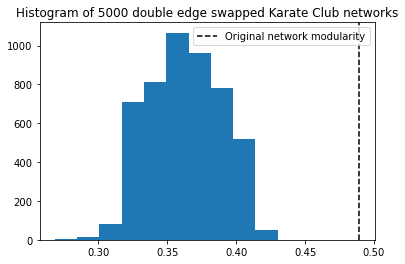

In [41]:
fig, ax = plt.subplots()
ax.hist(modularities)
ax.axvline(modularity(graph, "group"), c="k", linestyle="--", label="Original network modularity")
plt.title("Histogram of 5000 double edge swapped Karate Club networks")
plt.legend()
plt.show()

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

The club split, while far from optimal, is a very good partioning compared to the distribution of random networks with the same node degrees. The comparison to the configuration model makes sense, because modularity in some sense compares the numbers of edges inside groups to the expected number of edges inside those groups for a random network with the same degrees. A similar number of connections as the random networks means low modularity, while sparser group-group connections makes the modularity high. This is also why individual degrees should be preserved.

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

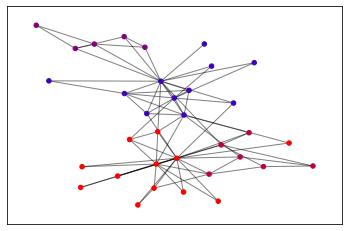

In [42]:
#first compute the best partition
partition = community.best_partition(graph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(graph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(graph, pos, list_nodes, node_size = 20,
                                node_color = [(count / size, 0, 1-count / size)] * len(list_nodes))


nx.draw_networkx_edges(graph,pos, alpha=0.5)
plt.show()

In [43]:
nx.set_node_attributes(graph, partition, name="louvain")
m = modularity(graph, 'louvain')
print(f"The modularity of the Louvain split is: {m:.3f}")

The modularity of the Louvain split is: 0.557


> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

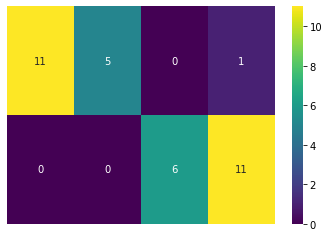

In [44]:
D = np.zeros((2, len(np.unique(list(partition.values())))))
club_map = {"Mr. Hi": 0, "Officer": 1}
for n in graph.nodes(data=True):
    data = n[1]
    i, j = club_map[data["group"]], data["louvain"]
    D[i, j] += 1

sb.heatmap(D, annot=True, cmap="viridis")
plt.axis("off")
plt.show()

The communities correspond relatively well with the actual club split. We see that to optimize modularity, we must add two additional smaller groups to the partition, where one of them corresponds to the isolated group within one of the clubs, and the other consists of the members with many connections in both groups.

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.

In [45]:
with open('author_graph.json') as f:
    network = json_graph.node_link_graph(json.load(f))
network = network.to_undirected(reciprocal=True)
nx.info(network)

C:\Users\runes\AppData\Local\Temp\ipykernel_20248\1220582739.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(network)


'Graph with 26394 nodes and 16963 edges'

In [46]:
gme_partition = community.best_partition(network)

names, counts = np.unique(list(gme_partition.values()), return_counts=True)

print("Number of communities:", len(names), "\n")

print("Biggest community:", np.max(counts))
print("Smallest community:", np.min(counts))
print("Mean community size:", np.mean(counts))
print("Median community size:", np.median(counts))

print("\nComputing node sets...")
gme_part_sets = [{k for k,v in gme_partition.items() if v == val} for val in set(gme_partition.values())]

print("Computing modularity...")
nx.set_node_attributes(network, gme_partition, name="louvain")
gme_m = nx.algorithms.community.modularity(network, gme_part_sets)
print(f"The modularity of the Louvain split is: {gme_m:.3f}")

Number of communities: 16499 

Biggest community: 519
Smallest community: 1
Mean community size: 1.5997333171707375
Median community size: 1.0

Computing node sets...
Computing modularity...
The modularity of the Louvain split is: 0.667


In [47]:
from tqdm import tqdm
modularities = []
for i in range(100):
    if i % 10 == 0: print(i)
    g = nx.double_edge_swap(network.copy(), nswap=10000, max_tries=20000)
    m = nx.algorithms.community.modularity(g, gme_part_sets)
    modularities.append(m)

0
10
20
30
40
50
60
70
80
90


In [48]:
print("Mean modularity:", np.mean(modularities))
print("Std  modularity:", np.std(modularities))

print("Is the modularity significantly different:", (np.mean(modularities) + 2*np.std(modularities)) < gme_m)

Mean modularity: 0.26127640090803933
Std  modularity: 0.004090725597712919
Is the modularity significantly different: True



(brave:218663): Gtk-WARNING **: 22:55:30.081: Theme parsing error: gtk.css:73:46: The style property GtkScrolledWindow:scrollbars-within-bevel is deprecated and shouldn't be used anymore. It will be removed in a future version
libva error: /usr/lib/dri/i965_drv_video.so init failed
[218701:218701:0100/000000.230236:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.


Opening in existing browser session.


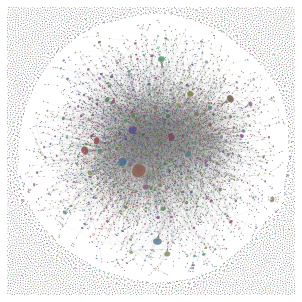

In [124]:
for name, data in network.nodes(data=True):
    data["group"] = gme_partition[name]
    
stylized_network, config = wulf.visualize(network)

We see many of the users outside the main cluster, since reciprocity was a condition for an edge to persist in this undirected graph. Apart from that, we have relatively few, but large, clusters, as indicated by our summary statistics above.